In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Load data
data_len = 1560

df_w = load_data(file_name=f"df_weekly_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_weekly_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [5]:
# predicted is y col
data_dict.update(predicted="sp_close_lead1")

# predictors are all X cols
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

# correlation

In [6]:
# select model features
cols = [item for item in data_dict["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     # 'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     # 'sp_close_lag1',
     # 'sp_close_lag2',
     # 'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
]

In [7]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [8]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["sp_cols"]] + ["sp_close"],
              data_dict["predicted"],
              show_plot=False,
             figsize=(5, 3))

[['vixo', 0, 0.47],
 ['ff_M_RF', 0, 0.468],
 ['ff_SMB', 4, 0.061],
 ['ff_RMW', 0, 0.138],
 ['ff_CMA', 0, 0.106],
 ['termspread', 0, 0.093],
 ['aaii_Bullish', 0, 0.12],
 ['sp_close', 0, 0.791]]

In [9]:
# df_ws = shift_var_relative_to_df(df_ws, shift_var=["ff_CMA", 
#                                                    "vixo",
#                                                    "naaim_ind",
#                                                    "ff_HML"
#                                                    # "naaim_ind",
#                                                    # "aaii_Bullish"
#                                                   ], no_lags=[
#     1,
#     7,
#     # 8,
#     5
#     # 8,
#     # 6
# ])

# Multicolinerarity

,VIF,corr_sp_close_lead1
vixo,1.634593,-0.470477
ff_RMW,1.206803,-0.138401
ff_CMA,1.132821,-0.105523
termspread,1.015925,-0.092697
ff_SMB,1.081194,0.017925
aaii_Bullish,1.049815,0.119717
ff_M_RF,1.590387,0.468324
sp_close,2.228171,0.791001


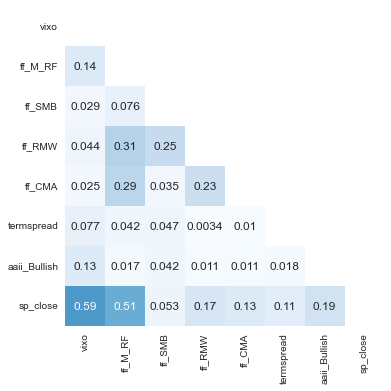

In [10]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             # size_factor=1,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Regression

In [11]:
df_train = df_ws.copy()

In [12]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.2, add_const=True)

In [13]:
model = SKLearnWrap(sm.OLS, fit_intercept=False)
model_ = model.fit(X_train, y_train)

In [14]:
model.results_.pvalues < .05

vixo            False
ff_M_RF          True
ff_SMB          False
ff_RMW          False
ff_CMA          False
termspread       True
aaii_Bullish    False
sp_close         True
intercept       False
dtype: bool

In [15]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     291.7
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          1.18e-280
Time:                        14:12:15   Log-Likelihood:                 3653.7
No. Observations:                1272   AIC:                            -7289.
Df Residuals:                    1263   BIC:                            -7243.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
vixo            -0.0006      0.004     -0.146      0.884      -0.009       0.008
ff_M_RF          0.0020      0.000      4.749      0.000       0.001       0.003
ff_SMB           0.0005      0.001      0.757      0.449      -0.001       0.002
ff_RMW           0.0005      0.001      0.528      0.598      -0.001       0.002
ff_CMA          -0.0002      0.001     -0.214      0.830      -0.002       0.002
termspread       0.0050      0.003      1.977      0.048    3.81e-05       0.010
aaii_Bullish    -0.0026      0.002     -1.418      0.156      -0.006       0.001
sp_close         0.7556      0.024     31.237      0.000       0.708       0.803
intercept        0.0003      0.000      0.766      0.444      -0.000       0.001
==============================================================================
Omnibus:                       99.842   Durbin-Watson:                   2.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              532.873
Skew:                           0.002   Prob(JB):                    1.94e-116
Kurtosis:                       6.171   Cond. No.                         74.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

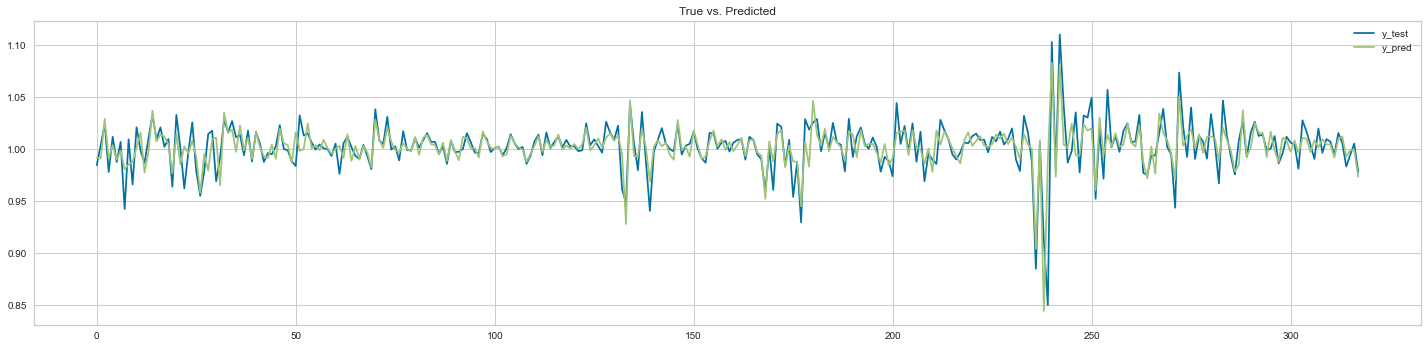

Validation Scores
mean squared error: 0.000241
mean absolute error: 0.010004
R2: 0.576329


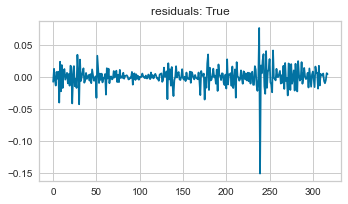

Stationarity Test Results
P-Values: 2.823218650275404e-10
Test-stats: -7.169842917468965
Time series is stationary: True


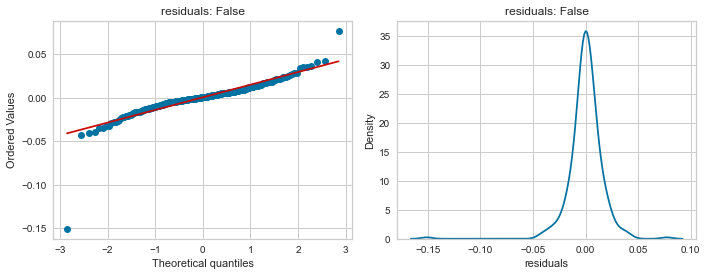

Normality Test Results
P-Values: 1.8446936784978443e-49
Test-stats: 224.42871264182872
Series is normally distributed: False


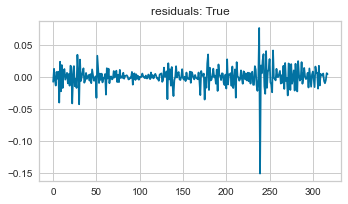

Test for Heteroskedasticity
Test p-value: 2.3398681006426494e-39
Heteroskedasticity is present: True


In [16]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(
    X_train=X_train,
    y_train=y_train,
    X_validate=X_test,
    y_validate=y_test,
    model=model_,
    data_dict=data_dict)

mval.get_model_performance()
mval.analyse_resids(print_results=True)

<module 'matplotlib.pyplot' from 'C:\\Users\\LukasGrahl\\Documents\\GIT\\bachelor\\bachelor_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

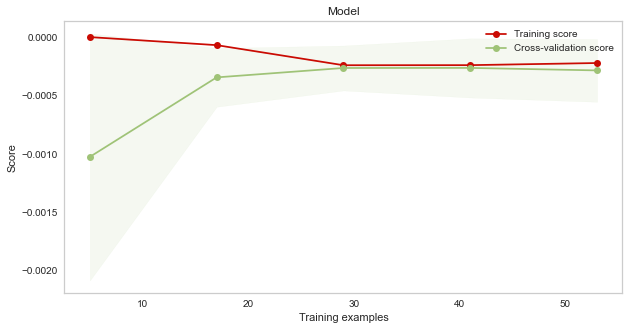

In [17]:
mval.plot_sm_learning_curve("Model", n_splits=5)

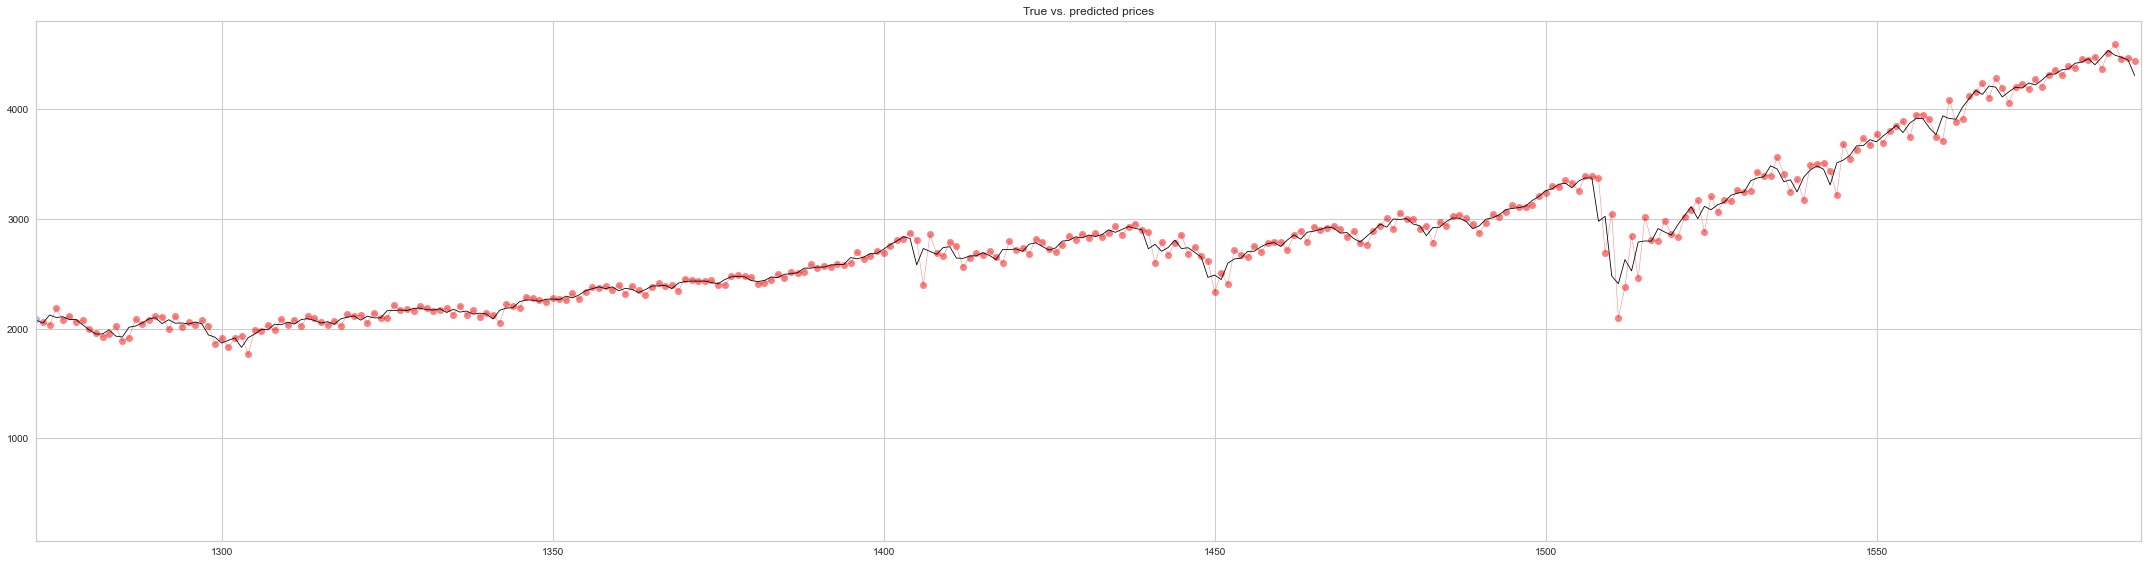

Validation Scores Test Data
mean squared error: 7775.38418
mean absolute error: 56.717805
mean absolute error in %: 0.04038993680396896
r2: 0.98207


In [20]:
mval.plot_results_on_price_scale(df_w,
                                 df_ws,
                                 show_pred_only=True)

# Save model

In [21]:
save_model(df_train, model, mval, data_dict, name=f"ols_{data_len}_{data_dict['predicted']}", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-13_ols_1560_sp_close_lead1_model.pkl"? (y/n)


 n
